# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

In [ ]:

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopandas

with open('NOW_data.txt', 'r') as f:
    sets = []
    #Get lines from txt and append them to a list
    for i in f: 
        sets.append(i.split(","))
    #Create dataframe
    df = pd.DataFrame(sets[1:],columns=sets[0]) 
    #Create csv from dataframe
    pd.DataFrame.to_csv(df,"NOW_data.csv") 
    print(df.shape)

df = df.replace("\\N",None)


(84928, 102)


Excercise 2. Created dataframe from data in txt and created a csv. The dataframe has 84928 rows.

In [ ]:
#3.a)
df["LAT"] = pd.to_numeric(df["LAT"]) 
df["LONG"] = pd.to_numeric(df["LONG"])
#Remove rows with lat=long=0. 0 rows satisfy this condition
df = df.loc[~((df["LONG"]==0)&(df["LAT"]==0)),:] 
#Rows left after remowing sp. and indet. 62889
df = df[~((df["SPECIES"]=="sp.")|(df["SPECIES"]=="indet."))] 
print(df.shape)

df["MIN_AGE"] = pd.to_numeric(df["MIN_AGE"])
df["MAX_AGE"] = pd.to_numeric(df["MAX_AGE"])
df["MEAN_AGE"] = df["MAX_AGE"]/2+df["MIN_AGE"]/2
ages = []
ranges = [23,21.7,19.5,17.2,16.4,14.2,12.85,11.2,9.9,8.9,7.6,7.1,5.3,5,3.55,2.5,1.9,0.85,0.01]
#3. b) make a list with categories MN and add it as a column for dp.
for i in df["MEAN_AGE"]: 
    if i >= 23:
        ages.append("pre-MN")
    elif i < 0.01:
        ages.append("post-MN")
    else:
        for j in range(len(ranges)-1):
            if j<6 and ranges[j]>i>=ranges[j+1]:
                ages.append(f"MN{j+1}")
                break
            elif j==6 and ranges[j]>i>=ranges[j+1]:
                ages.append("MN7-8")
                break
            elif j>6 and j<16 and ranges[j]>i>=ranges[j+1]:
                ages.append(f"MN{j+2}")
                break
            elif j>=16 and ranges[j]>i>=ranges[j+1]:
                ages.append(f"MQ{j+2}")
df["AGE"] = ages

#3.c) 
df.loc[df["NAME"]=="Samos Main Bone Beds","AGE"] = "MN12" 
df.loc[df["NAME"]=="Can Llobateres 1","AGE"] = "MN9"

#3.d) Label each species by an id. First create ids for GENUS SPECIES, then assgn each GENUS SPECIES 
# with the id.
ids = df[["GENUS","SPECIES"]].drop_duplicates().reset_index()   
mapping = {(ids.iloc[i,1]+" "+ ids.iloc[i,2]):i for i in range(len(ids))}
df["GENUSSPECIES"] = df["GENUS"]+" "+ df["SPECIES"]
df["SPECIES_ID"] = df["GENUSSPECIES"].map(mapping)
#3.e) Drop duplicate rows for columns LIDNUM and species_id
df = df.drop_duplicates(subset=["LIDNUM","SPECIES_ID"]) 
#3.f) We are left with 62828 rows
print(len(df))  
#Number of unique species
print(len(df.drop_duplicates("SPECIES_ID")))
#Number of unique localities
print(len(df.drop_duplicates("LIDNUM"))) 

(62889, 102)
62828
11336
7179


3.a Removed the LAT=LONG=0 rows. (0 rows removed). Removed SPECIES= np. and SPECIES = indet., and was left with 62889 rows.
3.b made column "AGE" changing age to MN format correctly
3.c Changed the "AGE" with NAME= "Samos Main Bone Beds","Can Llobateres 1" to MN12 and MN9 correspondingly
3.d Labeled each species by an id by first gatherig all GENUS SPECIES pairs with no duplicates and then mapping the id to all rows with that pair.
3.e Dropped duplicaterows with module drop_duplicates
3.f Print the amount of rows. We were left with 62828 rows. and there are 11336 unique species and 7179 unique localities.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20220\271093441.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  firsts = firstobserved.groupby("AGE")["count"].sum() #The amount of firstoccurances for each age
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20220\271093441.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = occurances_sorted.groupby("AGE")["count"].sum().reset_index(name="count")


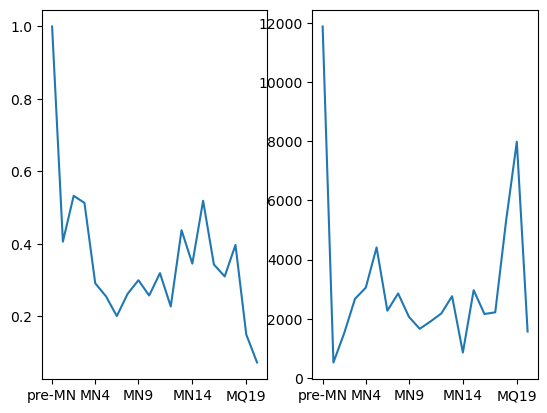

62828


In [ ]:
custom_order = ["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", 
                "MN9", "MN10", "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", 
                "MN17", "MQ18","MQ19", "post-MN"]
#Get a dataframe with count of the species in each age
occurances = df.groupby(["SPECIES_ID","AGE"]).size().reset_index(name="count") 
#Use custom-order to order the ages correctly
occurances['AGE'] = pd.Categorical(occurances['AGE'], categories=custom_order, ordered=True) 
occurances_sorted = occurances.sort_values(['SPECIES_ID', 'AGE'])

#Pick last row for each species. So the first occurance
firstobserved = occurances_sorted.groupby('SPECIES_ID').first().reset_index() 

#The amount of firstoccurances for each age
firsts = firstobserved.groupby("AGE")["count"].sum() 

total = occurances_sorted.groupby("AGE")["count"].sum().reset_index(name="count")

#Proportion of first occurances to all occurances
firstsprop = firsts/total["count"].to_numpy() 

fig, axes = plt.subplots(1, 2)
#Plot proportion of first occurances over time
axes[0].plot(firstsprop) 
axes[0].set_xticks(["pre-MN", "MN4", "MN9", "MN14", "MQ19"])
#plot all occurances over time
axes[1].plot(total["AGE"],total["count"]) 
axes[1].set_xticks(["pre-MN", "MN4", "MN9", "MN14", "MQ19"])
plt.show()
print(len(df))


Exercise 4. Here I did a dataframe that shows for all species the total amount of occurances for each age. This involved doing a custom-order for the ages.

Then I took for each species the last row to get the first occurance age and the amount for that age.

After that I did a dataframe with the proportions of first occurances to total occurances.

I plotted that and then I plotted all occurances over time. For oldest ages all of the occurances are first occurances which makes sense, because there are no older ages. The proportion of first occurances drops with the age getting newer. The newest occurances are rarely first occurances. For pre-MN there are a lot of occurances but after that the amonunt is fairly low until it peaks at MN18-MQ19

(7179, 4)
(62828, 3)


c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

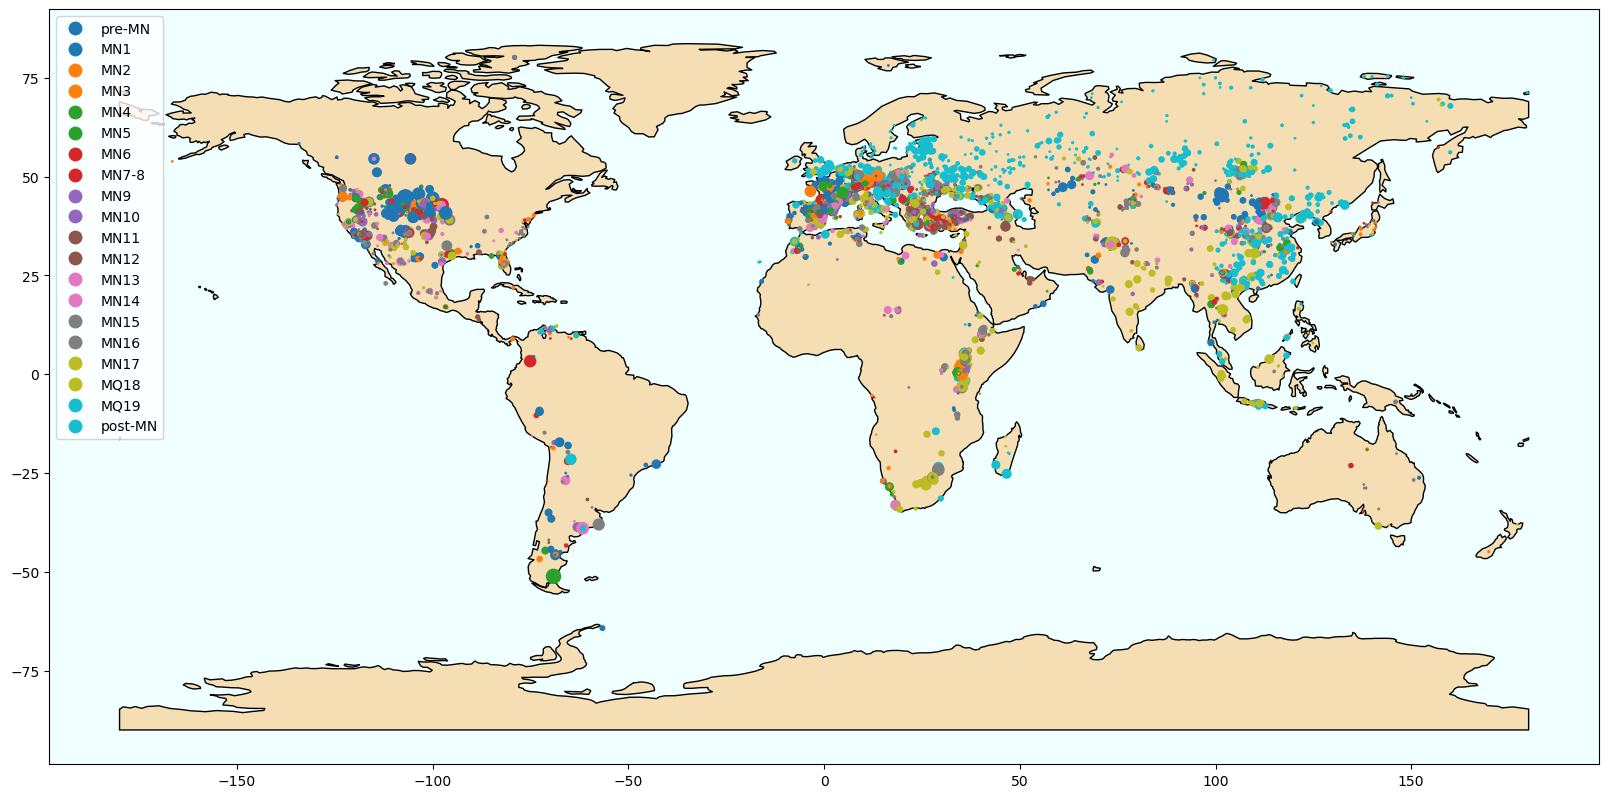

In [ ]:

import geodatasets
import geopandas.geodataframe
import shapely

#5 a) Create a dataframe with LIDNUM LONG LAT and AGE
localities = df[["LIDNUM","LONG","LAT","AGE"]].drop_duplicates("LIDNUM") 
#The number of occurances for each locality
numoccurancesloc = df.groupby("LIDNUM").size().reset_index(name="OCCURANCES") 
print(df[["LIDNUM","SPECIES_ID","AGE"]].shape)
#Merge to get number of first occurances for each location
locfirstsonly = df[["LIDNUM","SPECIES_ID","AGE"]].merge(firstobserved.drop("count",axis=1),on=["SPECIES_ID","AGE"],how="right") 
locfirstsonly = locfirstsonly.drop("SPECIES_ID",axis=1)
locfirstsonly = locfirstsonly.groupby("LIDNUM").size().reset_index(name="FIRSTS_COUNT")
#Merge localities dataframe with first occurances number and all occurances
localities = localities.merge(locfirstsonly,on="LIDNUM",how="left") 
localities = localities.merge(numoccurancesloc,on="LIDNUM",how="left")
#Some localities don't have any first occurances, so they were nan in the dataframe. Make them 0 instead
localities = localities.where(localities.notna(),0)
#Get the ratio of firsts to all occurances in a locality
localities["FIRSTS_RATIO"] = localities["FIRSTS_COUNT"]/localities["OCCURANCES"] 

localities["AGE"] = pd.Categorical(localities['AGE'], categories=custom_order, ordered=True)
world = geopandas.read_file(geodatasets.get_url("naturalearth land"))

fig , ax = plt.subplots( figsize= ( 20 , 10 ))
world.plot( ax=ax ,color="wheat",edgecolor="black")
ax.set_facecolor( "azure" )
#5 b) Make geodataframe with the points
asd =  geopandas.GeoDataFrame(localities.drop(['LAT', 'LONG',"AGE","FIRSTS_COUNT","OCCURANCES","FIRSTS_RATIO"], axis=1),crs={'init': 'epsg:4326'},geometry=[shapely.geometry.Point(xy)
                                 for xy in zip(localities["LONG"], localities["LAT"])]) 
#plot the points and set pointcolours by age and pointsize by occurance amount
asd.plot(ax=ax, marker='o', column=localities["AGE"],legend=True, markersize=localities["OCCURANCES"])



Excersize 5.a Created the dataframe with columns locality number (LIDNUM), longitude, latitude,
time unit, number of first occurrences in the locality, number of all occurrences in the locality and proportion of first occurrences in the locality.
5 b Plotted the localities with colour corresponding to age and point size corresponding to number of occurances
5 c There are a lot of MQ19 fossils. In Asia and Russia there are a lot of singular MQ19 localities, whereas in Europe there are tons of all kinds of localities. In Africa the localities are located in limited regions and they are almost all fairly new MN3+. North America has quite a lot of localities as well and it seems to have many pre-MN localities with many occurances, also a lot of younger singular localities.

In [ ]:
print(len(localities))  #EXCERSIZE 6
#Create crossproduct with regard to LIDNUM so that we can compare each locality with every other locality
newloc = localities.merge(localities,how="cross",suffixes=('', "'")) 
print(len(newloc))
print(newloc)

7179
51538041
         LIDNUM   LONG     LAT   AGE  FIRSTS_COUNT  OCCURANCES  FIRSTS_RATIO  \
0         21390   8.05  47.383   MN6           1.0           1      1.000000   
1         21390   8.05  47.383   MN6           1.0           1      1.000000   
2         21390   8.05  47.383   MN6           1.0           1      1.000000   
3         21390   8.05  47.383   MN6           1.0           1      1.000000   
4         21390   8.05  47.383   MN6           1.0           1      1.000000   
...         ...    ...     ...   ...           ...         ...           ...   
51538036  22144  84.16  49.450  MQ19           4.0          19      0.210526   
51538037  22144  84.16  49.450  MQ19           4.0          19      0.210526   
51538038  22144  84.16  49.450  MQ19           4.0          19      0.210526   
51538039  22144  84.16  49.450  MQ19           4.0          19      0.210526   
51538040  22144  84.16  49.450  MQ19           4.0          19      0.210526   

         LIDNUM'       LO

In [ ]:
latdif = (newloc["LAT"]-newloc["LAT\'"]).abs()
longdif = (newloc["LONG"]-newloc["LONG\'"]).abs()
#Filter rows such that the localities are only 5 degrees from each other.
newloc = newloc[(latdif<=5)|(latdif>=175)] 
newloc = newloc[(longdif<=5)|(longdif>=355)]
print(newloc[["LIDNUM","LONG","LAT","LONG\'","LAT\'"]])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20220\3264467247.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newloc = newloc[(longdif<=5)|(longdif>=355)]


         LIDNUM   LONG     LAT      LONG'       LAT'
0         21390   8.05  47.383   8.050000  47.383000
1         21390   8.05  47.383   7.755959  47.243654
29        21390   8.05  47.383  12.367000  48.433000
33        21390   8.05  47.383  11.100000  43.000000
36        21390   8.05  47.383  11.223458  48.840252
...         ...    ...     ...        ...        ...
51537456  22144  84.16  49.450  84.680000  51.380000
51537739  22144  84.16  49.450  81.000000  45.000000
51537967  22144  84.16  49.450  84.950000  47.400000
51537977  22144  84.16  49.450  84.866389  47.283056
51538040  22144  84.16  49.450  84.160000  49.450000

[3147269 rows x 5 columns]


In [ ]:
#Choose only localities with the same age
occurancesinrange_SAMETIMEUNIT = newloc[newloc["AGE"]==newloc["AGE\'"]] 

#Groupby LIDNUM to get number of first occurances and total occurances in the range
occurancesinrange_SAMETIMEUNIT = occurancesinrange_SAMETIMEUNIT.groupby(["LIDNUM"])[["FIRSTS_COUNT\'","OCCURANCES\'"]].sum() 

#Define a function to get the previous age of a given age.
def prev_age(age): 
    if age in custom_order:
        if age == "pre-MN":
            return None
        else:
            return custom_order[custom_order.index(age)-1]
    else:
        return None

#Create a new column that states the previous age for the locality. If no previous age, then None
newloc["PREV_AGE"]= newloc["AGE"].apply(prev_age) 

#Choose those localities that have the previous age of a locality
occurancesinrange_PREVTIMEUNIT = newloc[newloc["PREV_AGE"]==newloc["AGE\'"]] 

#Get the sum of the occurances in range for previous age
occurancesinrange_PREVTIMEUNIT = occurancesinrange_PREVTIMEUNIT.groupby(["LIDNUM"])["OCCURANCES\'"].sum().reset_index(name="OCCURANCES_INRANGE_PREVTIME") 

#Add the results to the dataframe from excersize 5
localities2 = localities.merge(occurancesinrange_SAMETIMEUNIT,how="left",on="LIDNUM") 
localities2 = localities2.merge(occurancesinrange_PREVTIMEUNIT,how="left",on="LIDNUM")
#Rename the columns
localities2 = localities2.rename(columns={"FIRSTS_COUNT\'":"FIRSTS_INRANGE_SAMETIME","OCCURANCES\'":"OCCURANCES_INRANGE_SAMETIME"})
localities2["OCCURANCES_INRANGE_PREVTIME"] = localities2["OCCURANCES_INRANGE_PREVTIME"].where(~localities2["OCCURANCES_INRANGE_PREVTIME"].isna(),0)

print(localities2[["LIDNUM","OCCURANCES_INRANGE_PREVTIME","FIRSTS_INRANGE_SAMETIME","OCCURANCES_INRANGE_SAMETIME"]])

Index(['LIDNUM', 'LONG', 'LAT', 'AGE', 'FIRSTS_COUNT', 'OCCURANCES',
       'FIRSTS_RATIO', 'FIRSTS_COUNT'', 'OCCURANCES'',
       'OCCURANCES_INRANGE_PREVTIME'],
      dtype='object')
     LIDNUM  OCCURANCES_INRANGE_PREVTIME  FIRSTS_INRANGE_SAMETIME  \
0     21390                        967.0                     37.0   
1     29029                          0.0                   1427.0   
2     27232                         24.0                     20.0   
3     27955                        273.0                     64.0   
4     26550                        143.0                      1.0   
...     ...                          ...                      ...   
7174  21769                         23.0                     55.0   
7175  22524                         70.0                      5.0   
7176  22267                        104.0                    104.0   
7177  21071                         14.0                      2.0   
7178  22144                          0.0                

Excersize 6
First created a dataframe with the crossproduct of localities to compare each locality to every other locality.
Then filtered the localities such that each locality had only those localities that are in the 10 degrees by 10 degrees range.
Then filtered the localities such that each locality had localities with the same age and then groubed by locality to get the number of first occurances and total occurances in the range.
Then filtered localities such that each locality had only those localities with the previous age and then again groubed by locality to get the number of occurances in the range for the previous age.
Finally added these results to the dataframe from excersize 5

Optimization terminated successfully.
         Current function value: 0.535382
         Iterations 6


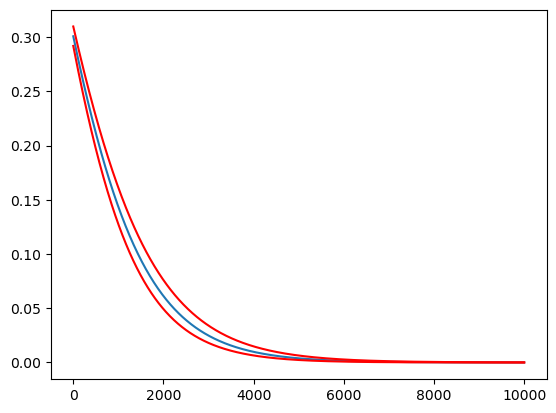

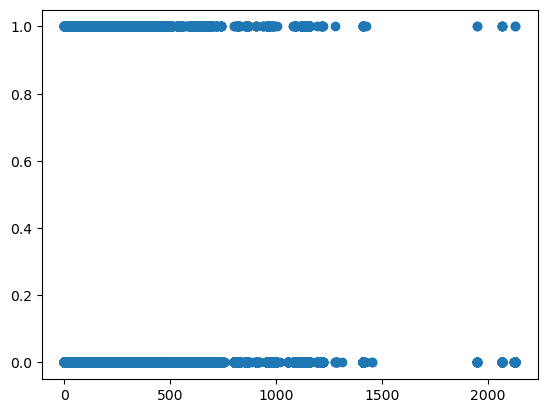

In [ ]:
import statsmodels.api as sm
import math

#3 a) Restrict occurances to those with LAT>35 and -25<LONG<40 and timeunit within MN2-MQ19
occurances_europe = df[(df["LAT"]>35)&(df["LONG"]<40)&(df["LONG"]>-25)&(df["AGE"]!="pre-MN")&(df["AGE"]!="post-MN")&(df["AGE"]!="MN1")]

#Merge occurances with localityinfo
occurances_europe2 = occurances_europe.merge(localities2.drop("AGE",axis=1),on="LIDNUM",how="left") 

firstobserved2 = firstobserved.rename(columns={"AGE":"FIRST_AGE"}).drop("count",axis=1)

#Get firstobserved info to the table
occurances_europe2 = occurances_europe2.merge(firstobserved2,on="SPECIES_ID",how="left")
#This column is for labelling with 1 and 0 if an occurance is a first occurance or not
occurances_europe2["y"] = (occurances_europe2["FIRST_AGE"]==occurances_europe2["AGE"]).astype(int)

#Get the dataframe with columns previous age first occurances in the range and y
regression_data = occurances_europe2[["OCCURANCES_INRANGE_PREVTIME","y"]]
#Renaming columns
regression_data = regression_data.rename(columns={"OCCURANCES_INRANGE_PREVTIME":"X"})


X = np.array(regression_data["X"])
y = np.array(regression_data["y"])
X = sm.add_constant(X)
#7 b) Logistic regression model
model = sm.Logit(y,X)
result = model.fit()
coefficients = result.params
X2 = np.linspace(0,10000,1000)
y_predict = 1/(1+math.e**(-(coefficients[0]+coefficients[1]*X2)))

confidence95 = result.conf_int(alpha=0.05)
y_confidencebot = 1/(1+math.e**(-(confidence95[0][0].T+confidence95[1][0]*X2)))
y_confidencetop = 1/(1+math.e**(-(confidence95[0][1].T+confidence95[1][1]*X2)))

#7 c)Plotted the regression curve and the 95%-confidence intervals
plt.plot(X2,y_predict)
plt.plot(X2,y_confidencebot,c="r") 
plt.plot(X2,y_confidencetop,c="r")
plt.show()
plt.scatter(regression_data["X"],y)
plt.show()


Excersize 7
a Restricted the occurances data to ones with LAT>35, -25< LONG < 40 and age between MN2 and MQ19. Merged data with firstoccurance data and locality data. Then created dataframe with first column having the amount of occurances in the previous age in the range, and the second column having 1 if occurance is a first occurance and 0 otherwise.

b Created Logistic regression using this data created in 7 a

c Plotted the logistic curve with the 95%-interval plotted in red

In [ ]:
#8 Restricted set of localities to Europe and calculated the probability of an 
# occurance in the locality being a first occurance(ie. the ratio of first occurances) 
# using the regression curve we got from 7. Localities with no 
# occurances in previous age are mapped to 1/(1+e^(c_0)).
localities_europe = localities2[(localities2["LAT"]>35)&(localities2["LONG"]<40)&(localities2["LONG"]>-25)]
expected_proportion = 1/(1+math.e**(-(coefficients[0]+coefficients[1]*localities2["OCCURANCES_INRANGE_PREVTIME"])))
print(expected_proportion)

0       0.147368
1       0.300733
2       0.295997
3       0.249522
4       0.273167
          ...   
7174    0.296193
7175    0.287041
7176    0.280527
7177    0.297965
7178    0.300733
Name: OCCURANCES_INRANGE_PREVTIME, Length: 7179, dtype: float64


8.Restricted set of localities to Europe and calculated the probability of an occurance in the locality being a first occurance(ie. the ratio of first occurances) using the regression curve we got from 7. Localities with no occurances in previous age are mapped to 1/(1+e^(c_0)).

In [ ]:
from scipy.stats import binom

localities2["EXPECTED_FIRSTS_RATIO"] = expected_proportion 
n,x,p = localities2["OCCURANCES_INRANGE_SAMETIME"],localities2["FIRSTS_INRANGE_SAMETIME"],localities2["EXPECTED_FIRSTS_RATIO"]
#Set the variables n as amount of occurances in the scope for the time of the locality, x as the 
# observed amount of first occurances in the scope in the time of the locality, and p as the expected 
# ratio of first occurances based on the logistic regression.

prop = 1-binom.cdf(x-1,n,p) 
#Calculate the propability P(X>=x)=1-P(X<=x-1) with the cumulative distribution function of binomial distribution.
print(prop)
localities2["p"] = prop 
#Add it as column to localities dataframe.


[1.         0.         0.87717421 ... 1.         0.74065844 0.9995877 ]


9. Set the variables n as amount of occurances in the scope for the time of the locality, x as the observed amount of first occurances in the scope in the time of the locality, and p as the expected ratio of first occurances based on the logistic regression. Then calculate the propability P(X>=x)=1-P(X<=x-1) with the cumulative distribution function of binomial distribution.

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


pre-MN


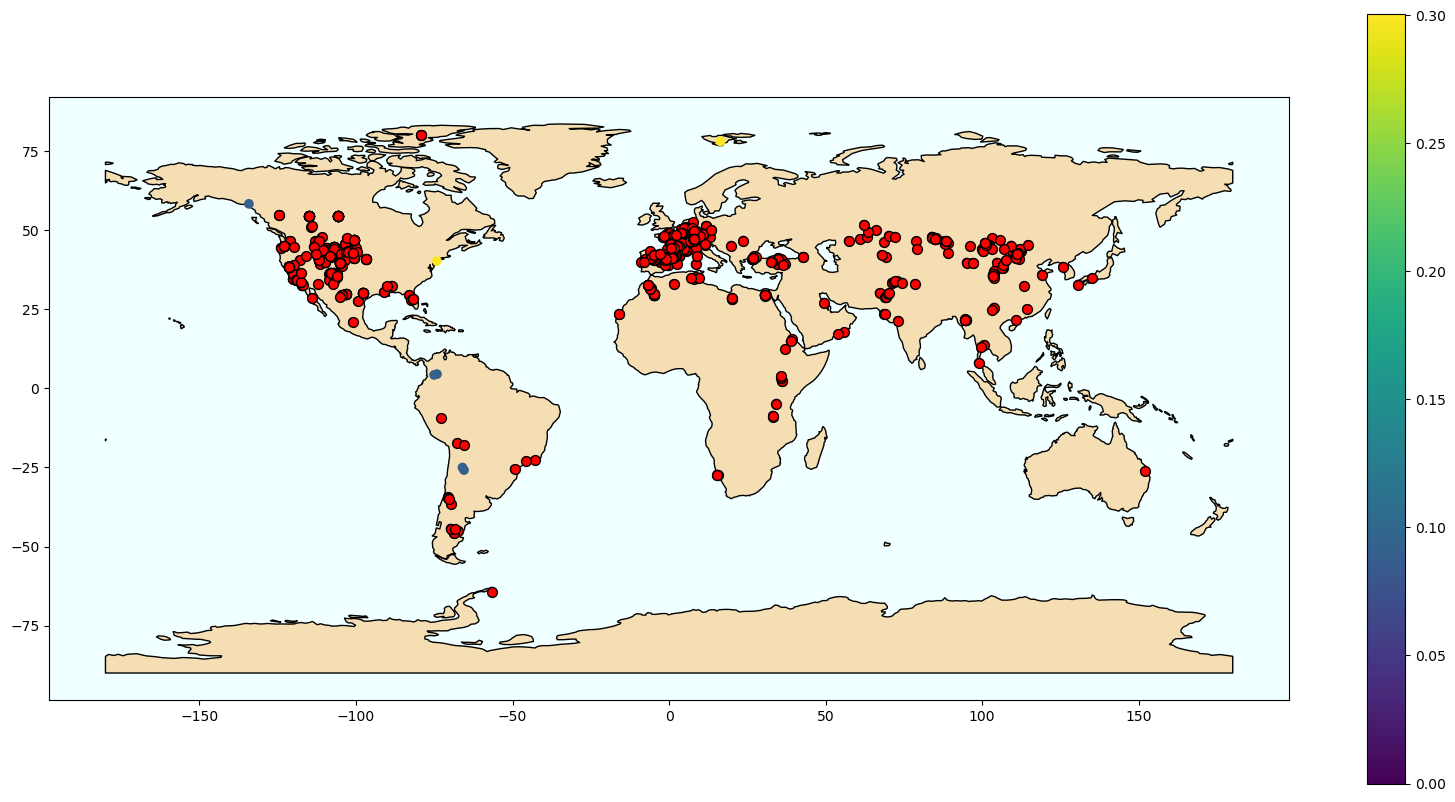

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN1


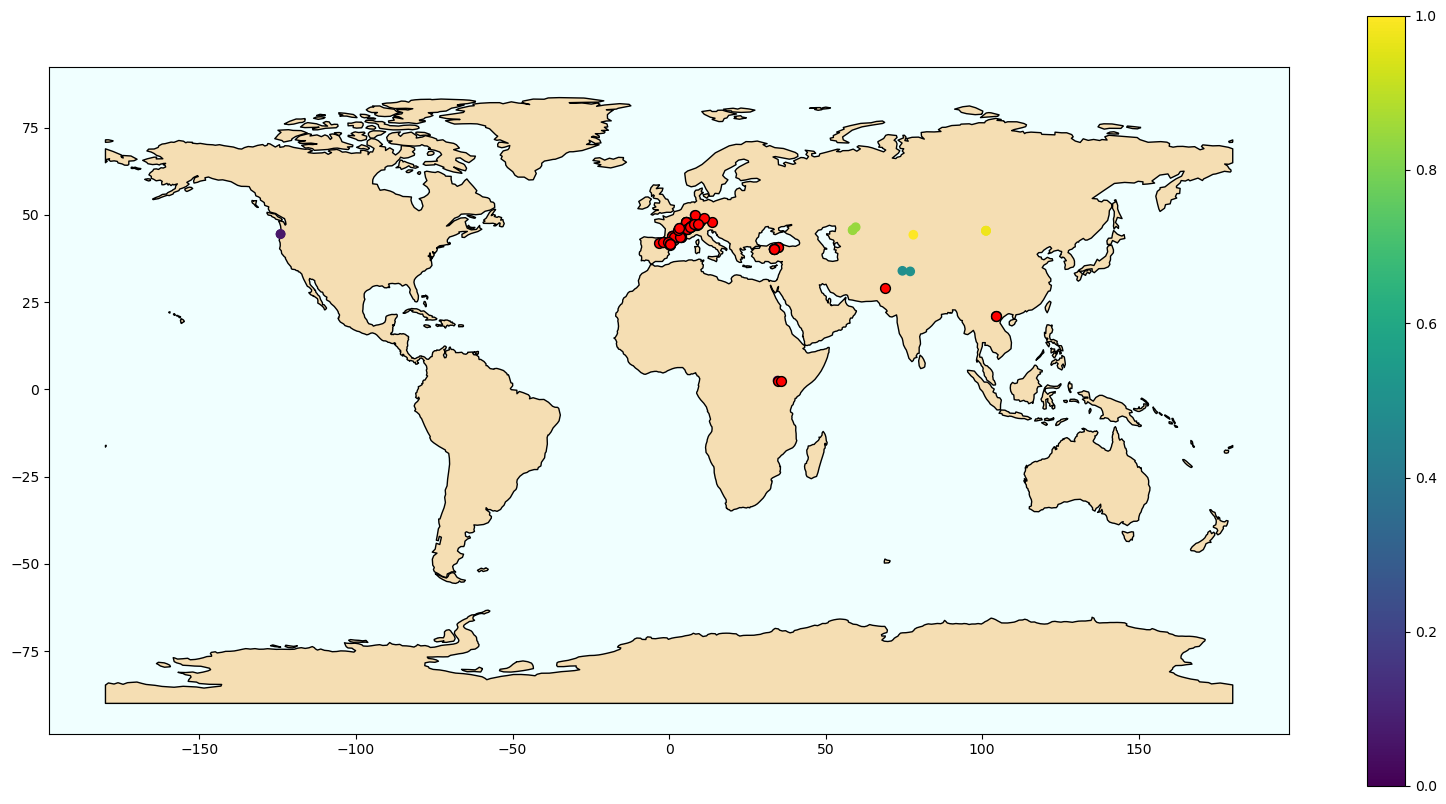

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN2


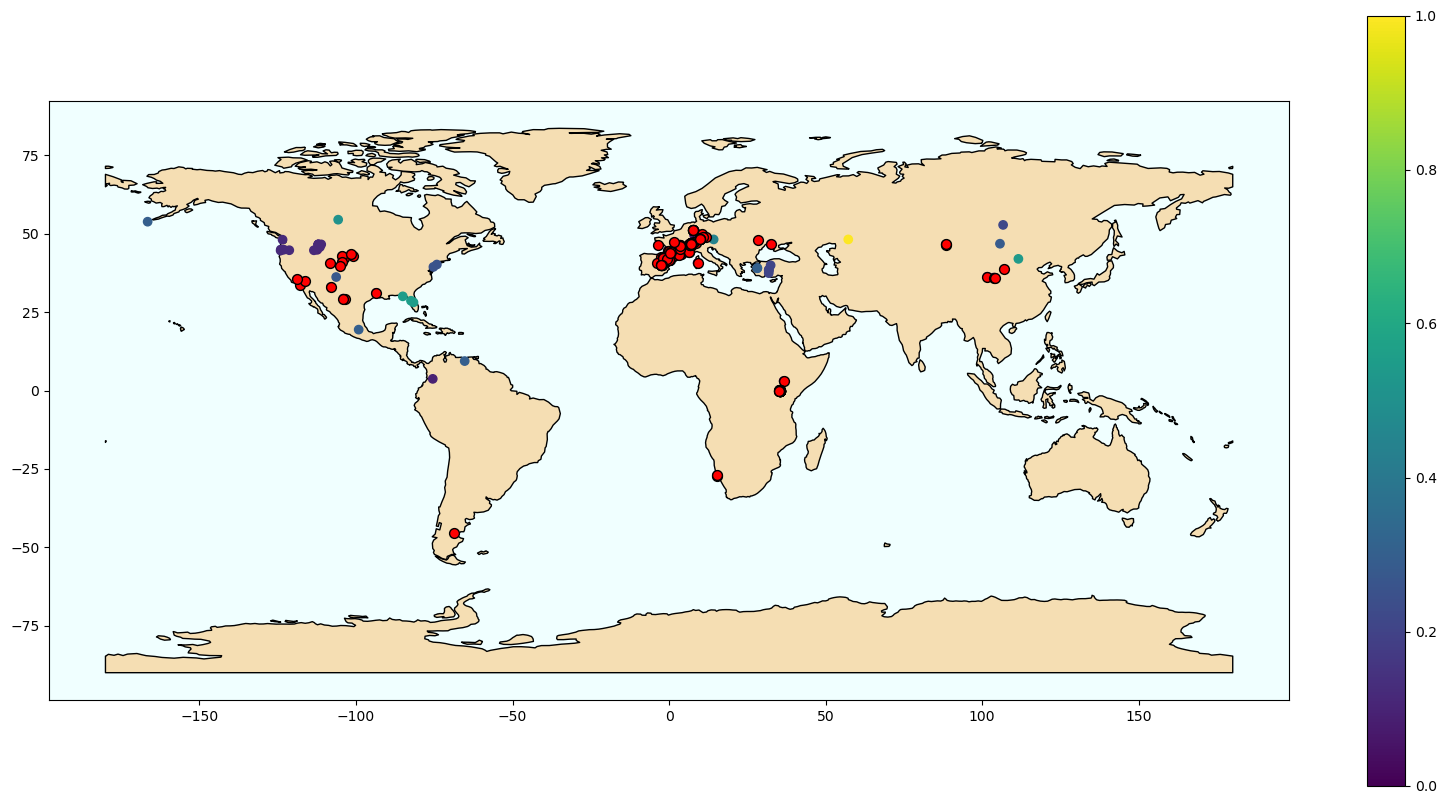

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN3


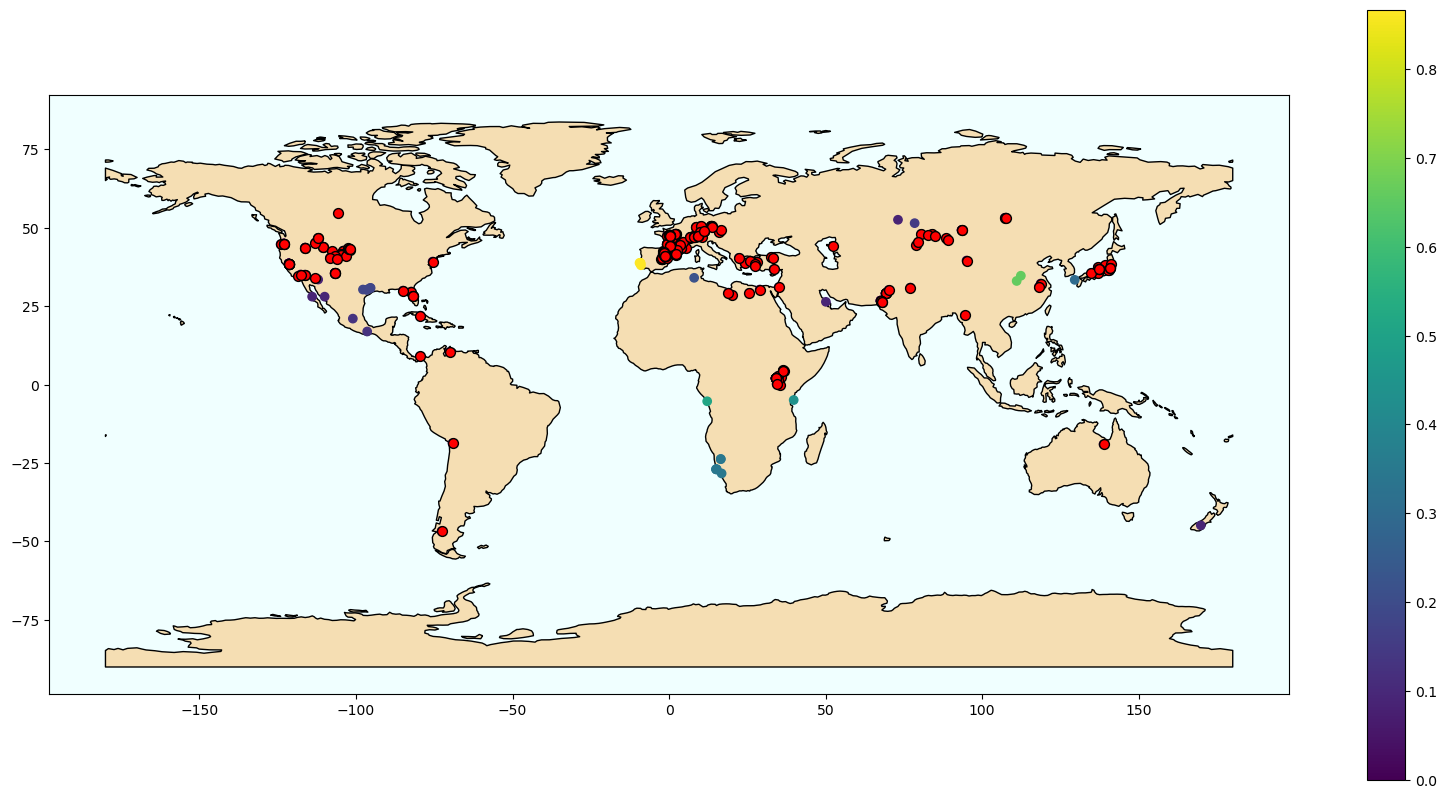

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN4


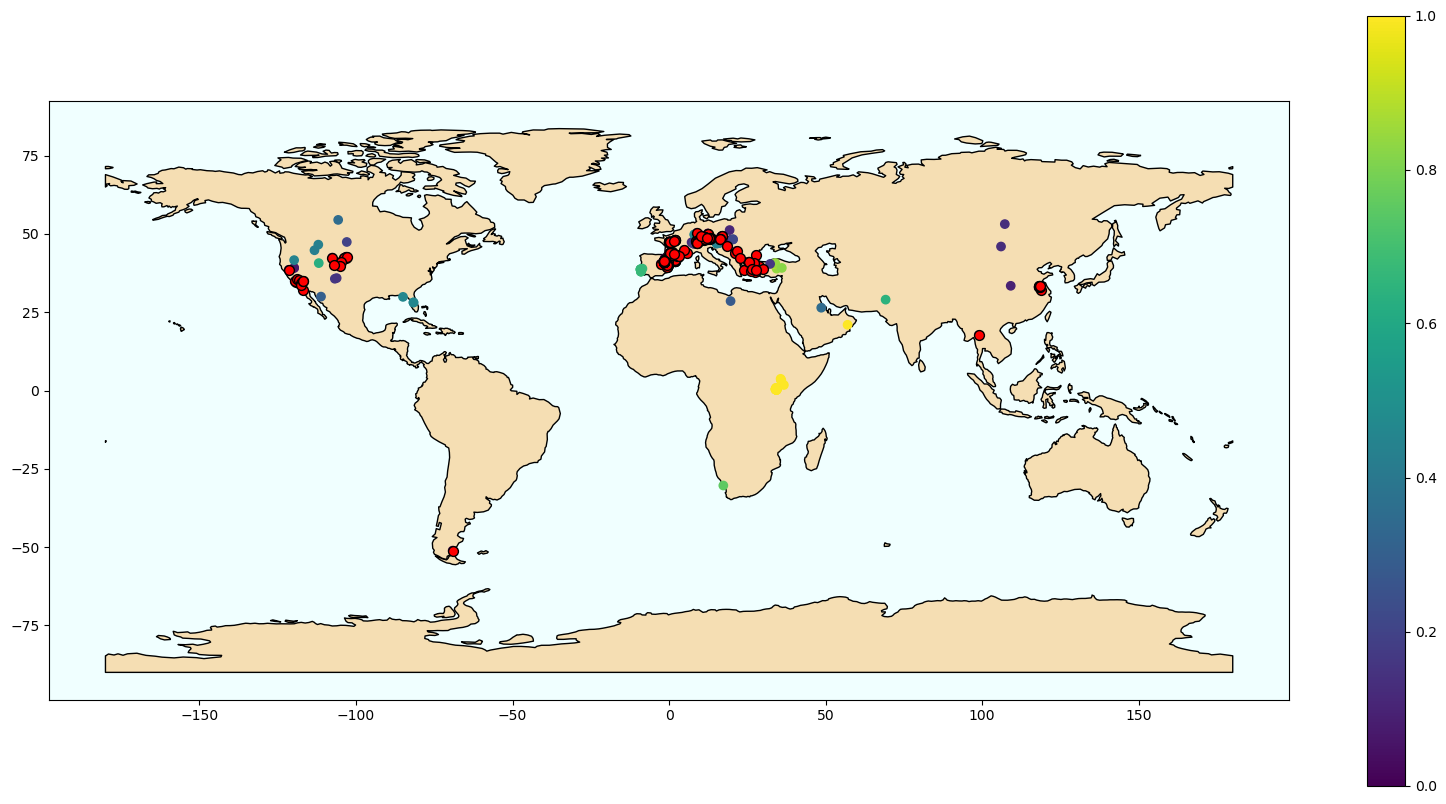

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN5


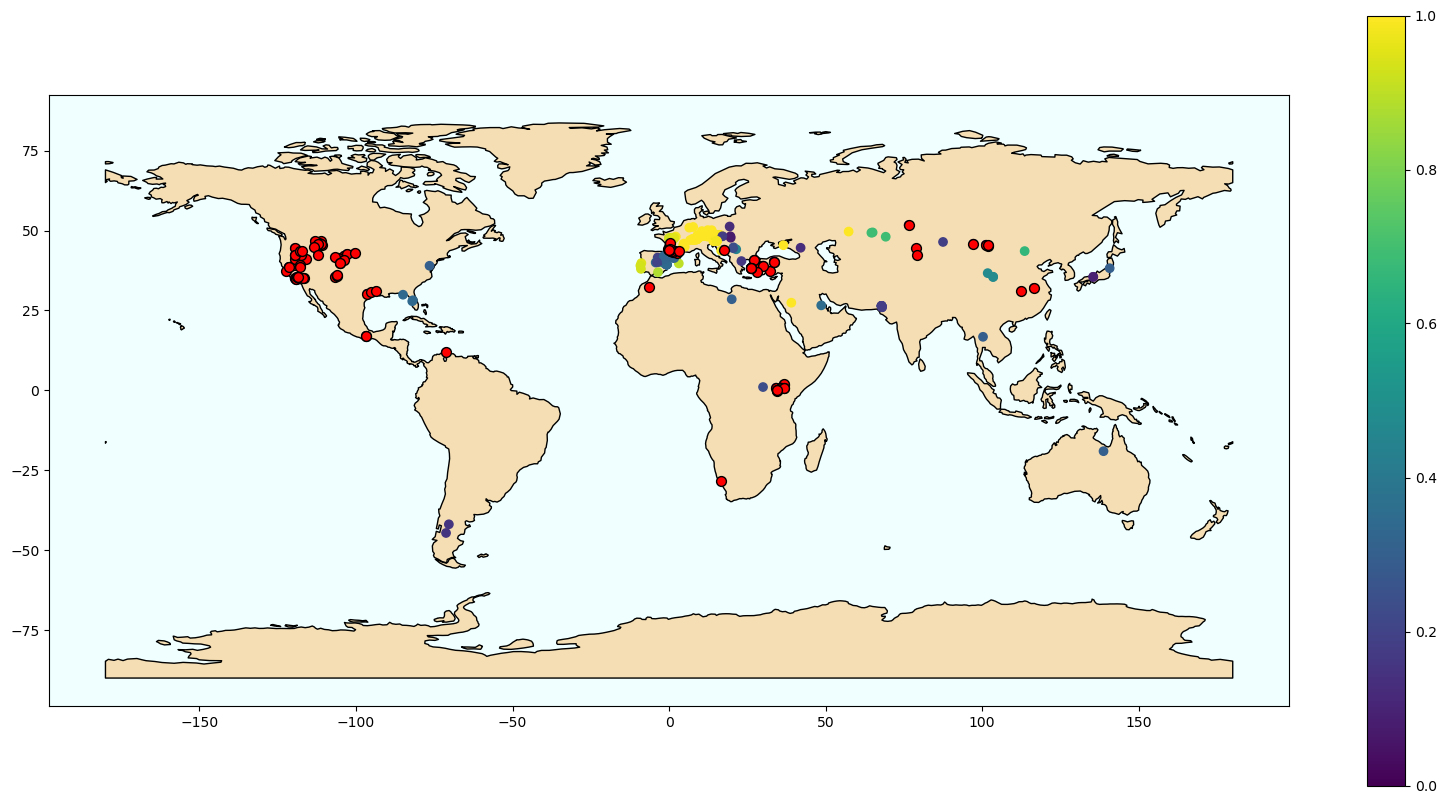

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN6


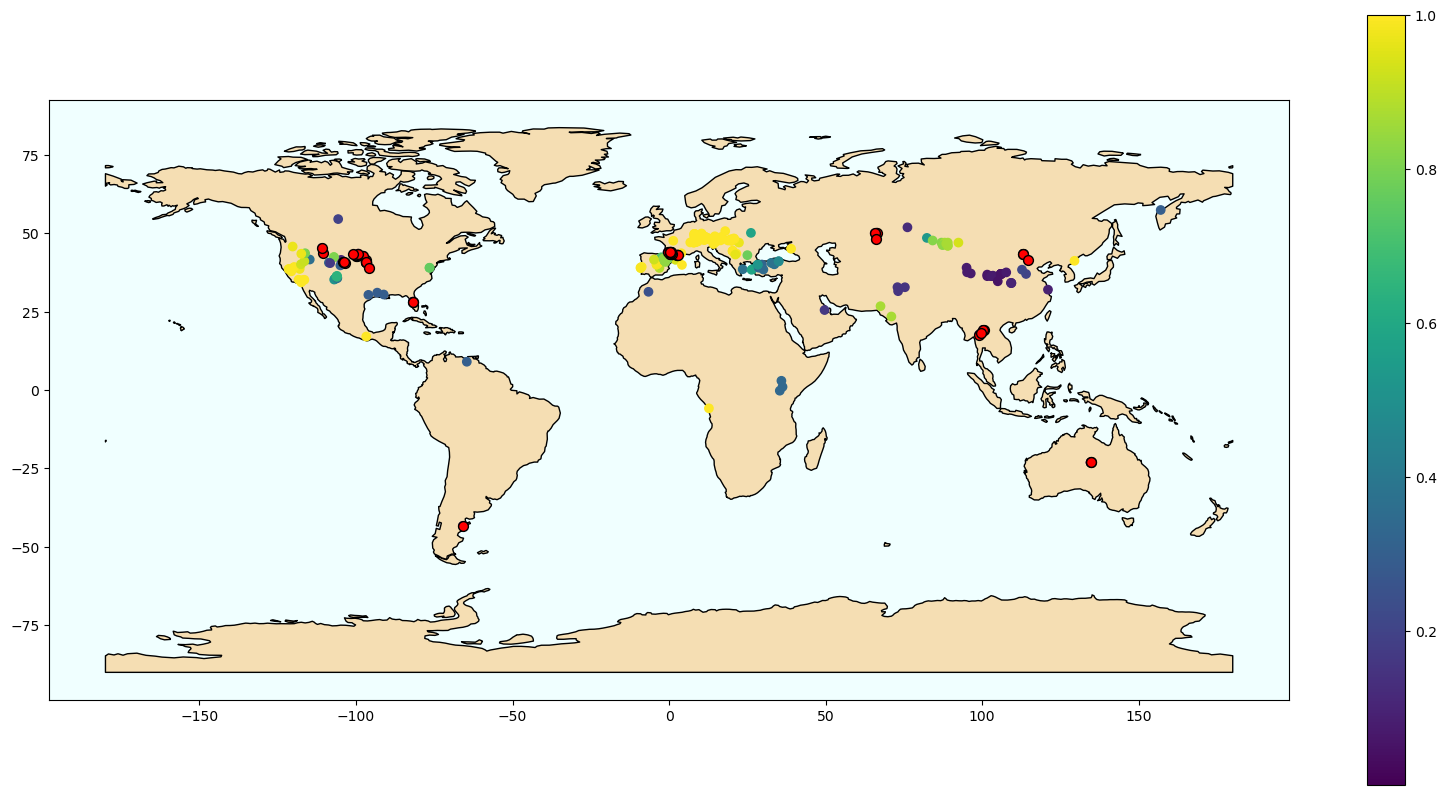

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN7-8


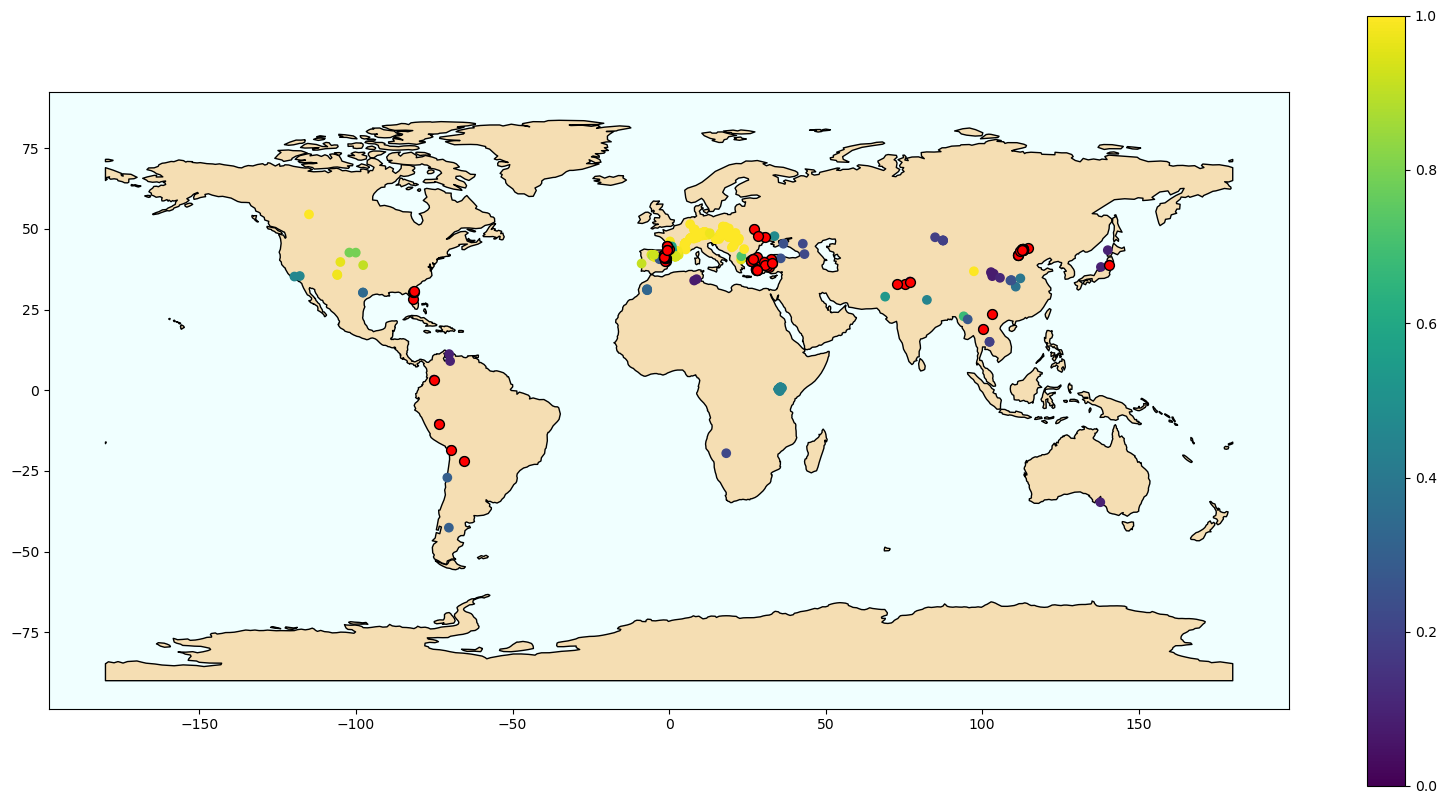

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN9


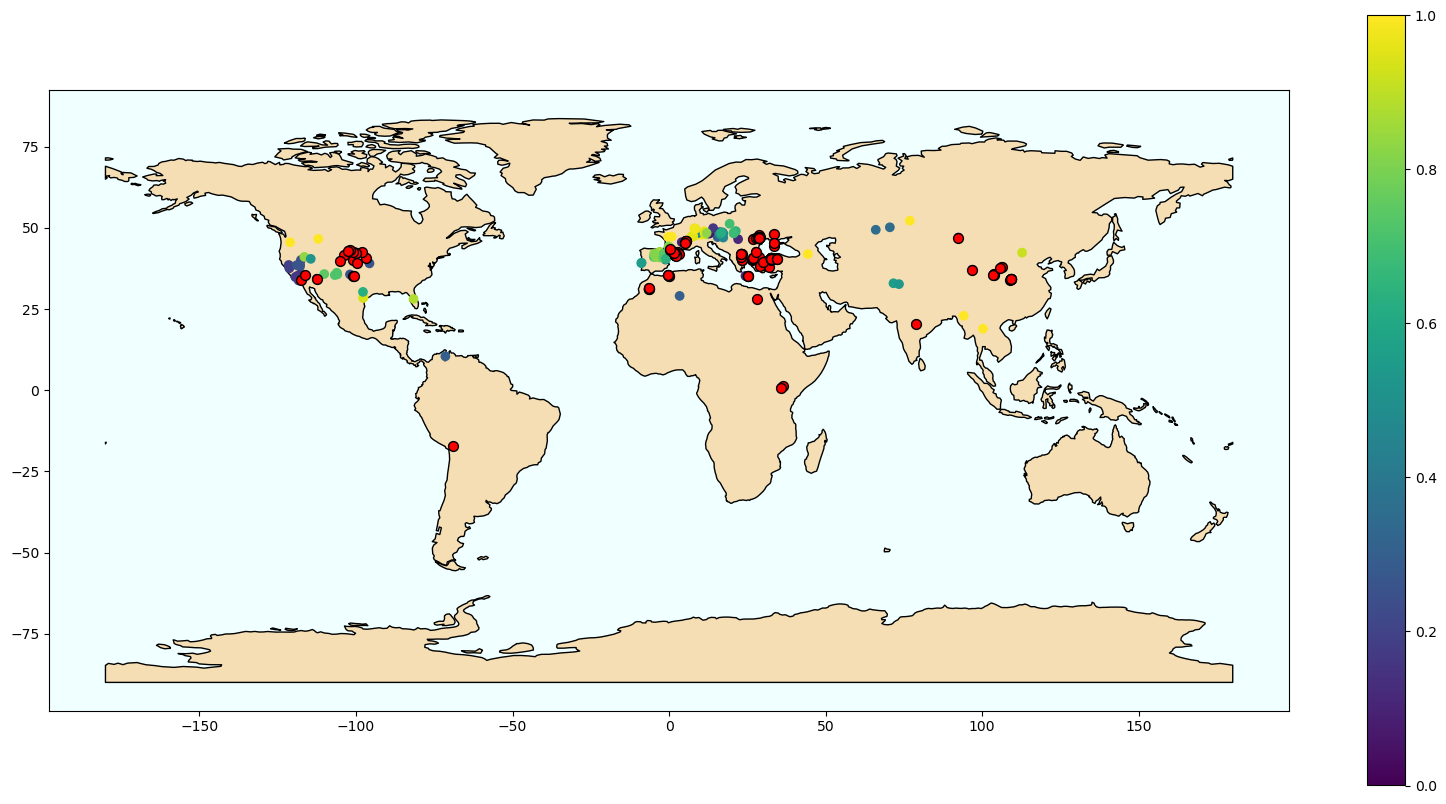

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN10


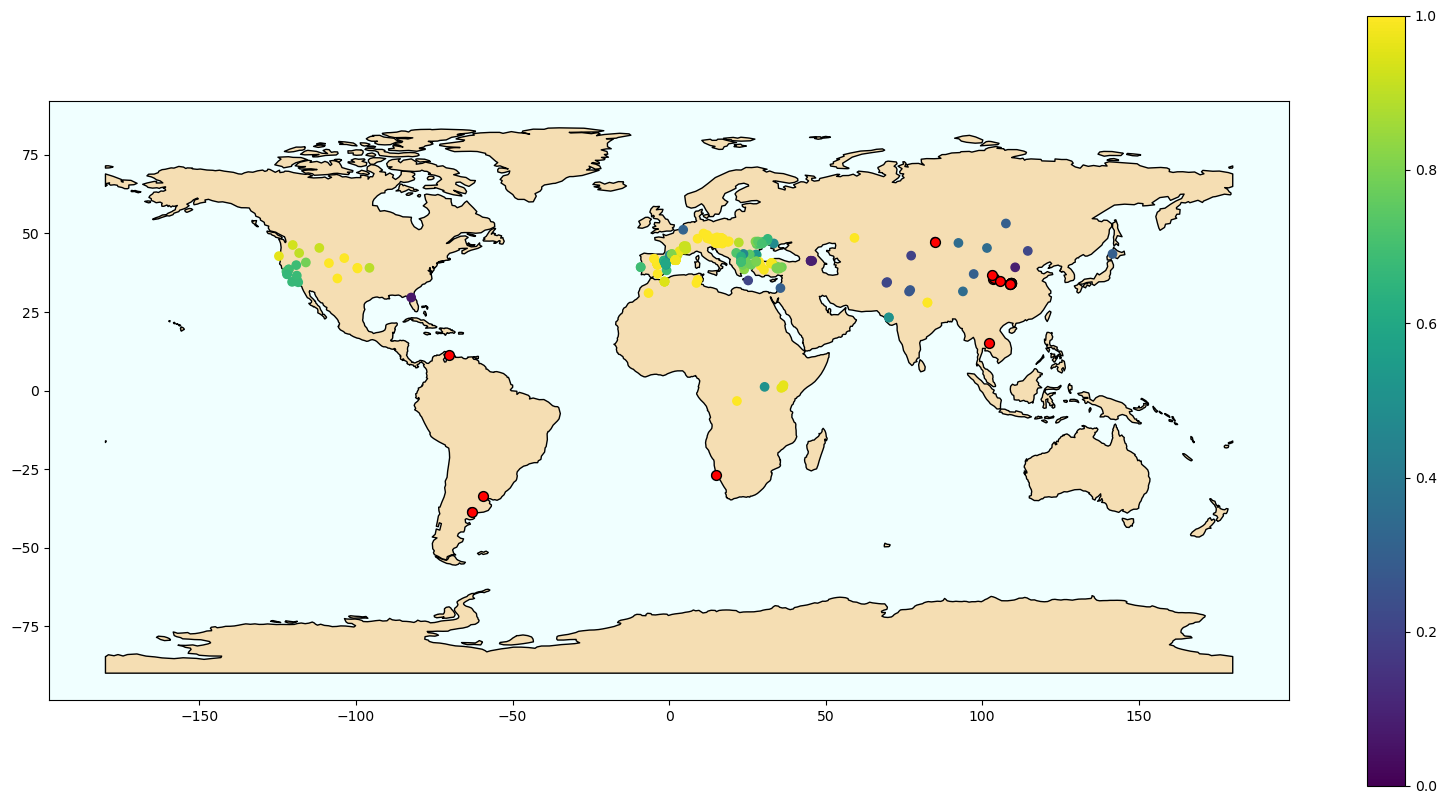

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN11


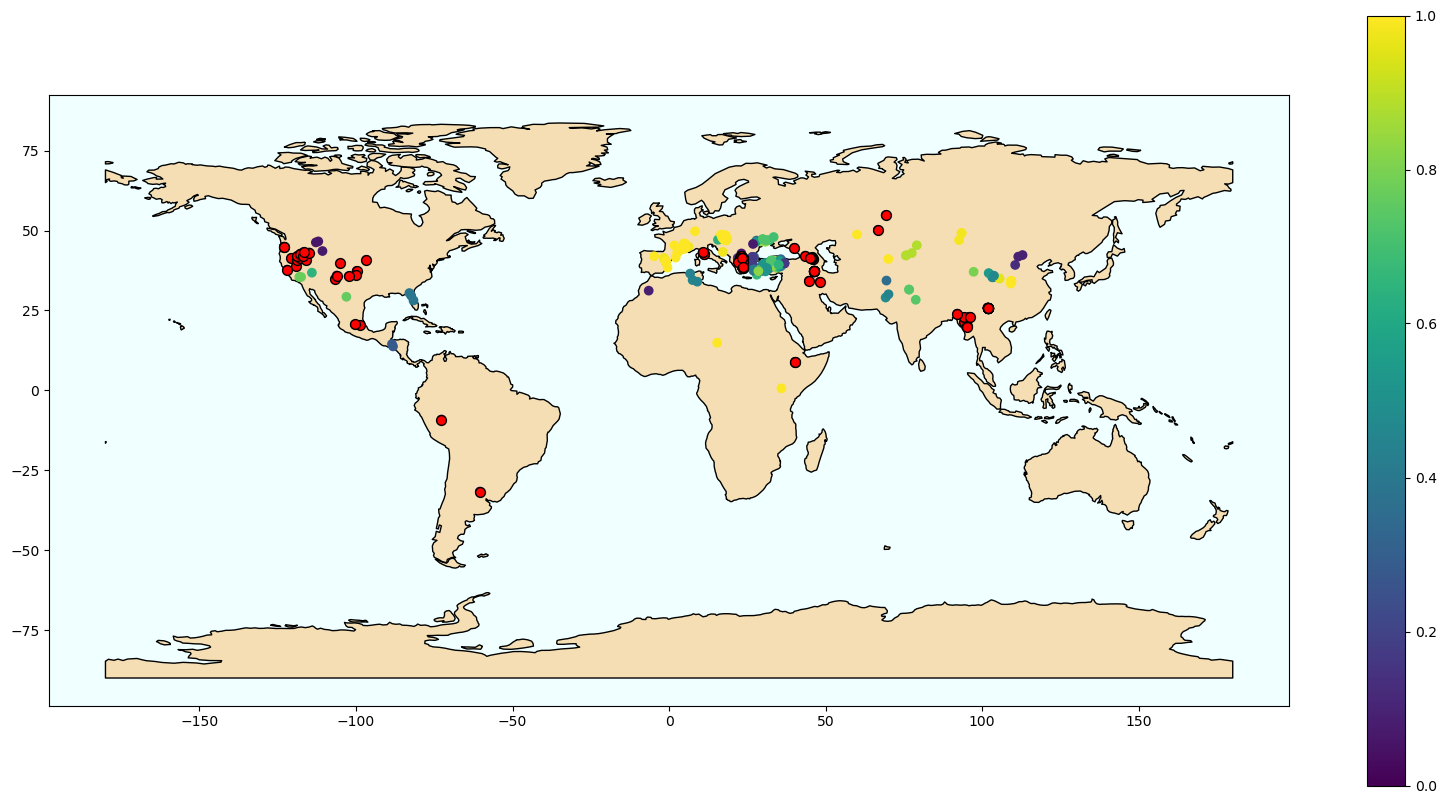

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN12


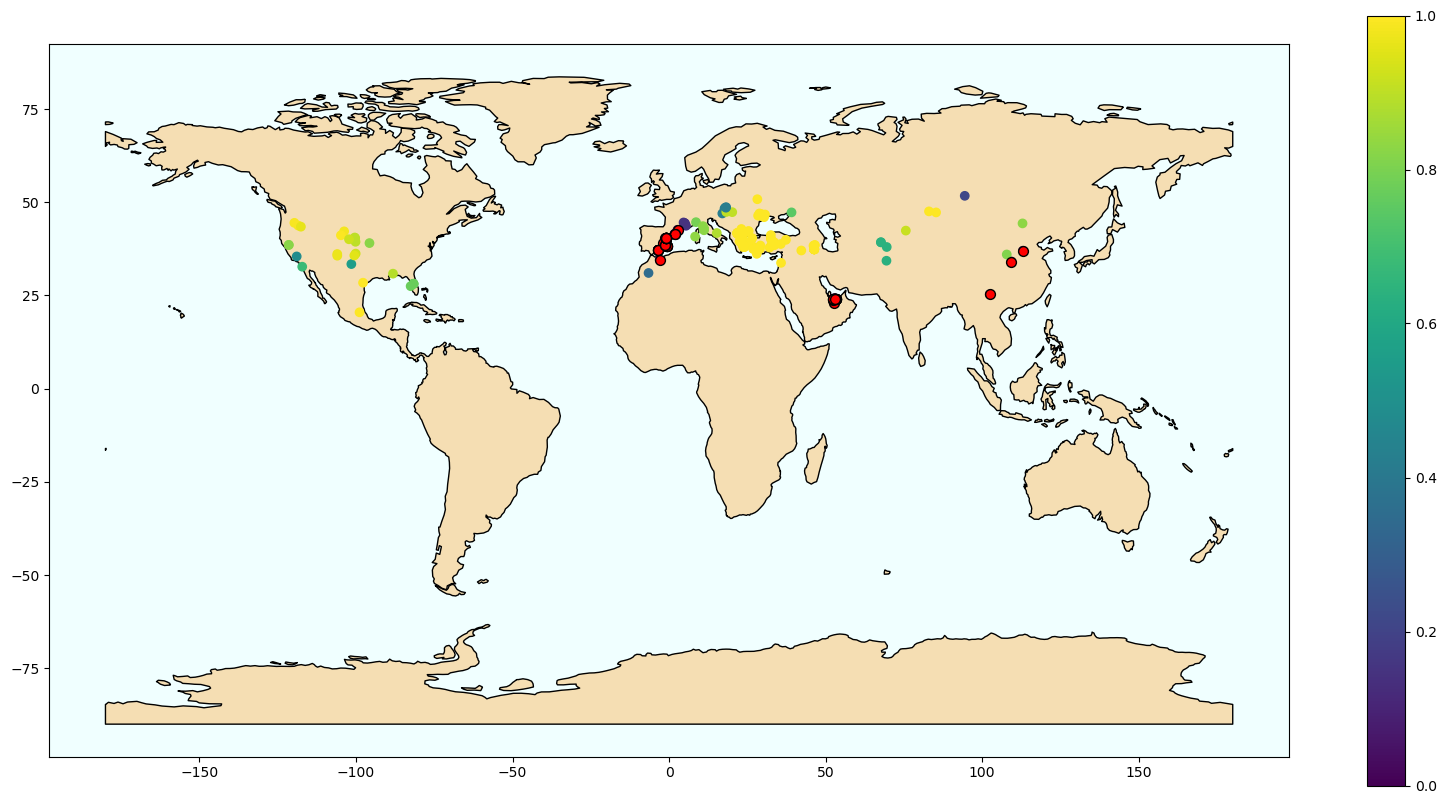

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN13


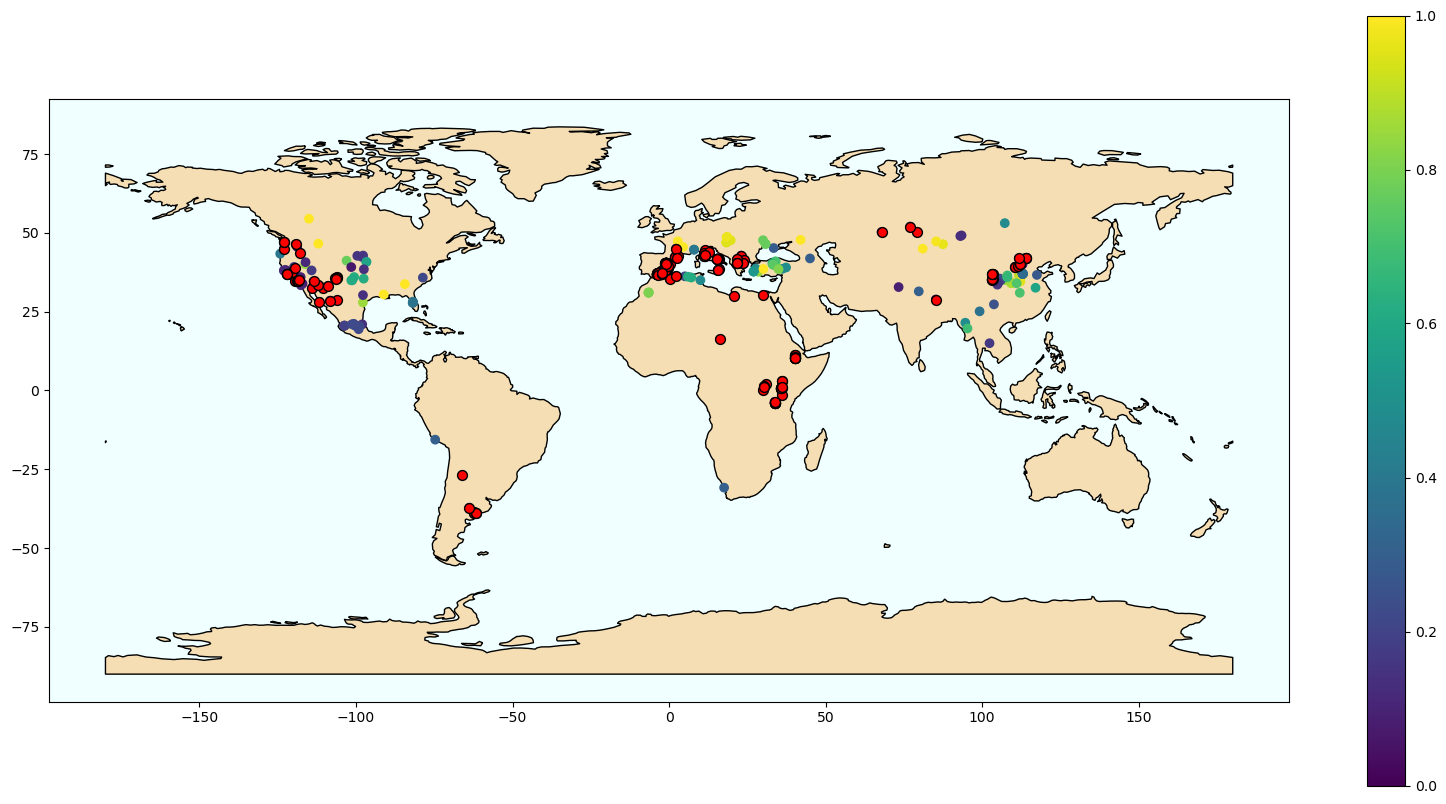

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN14


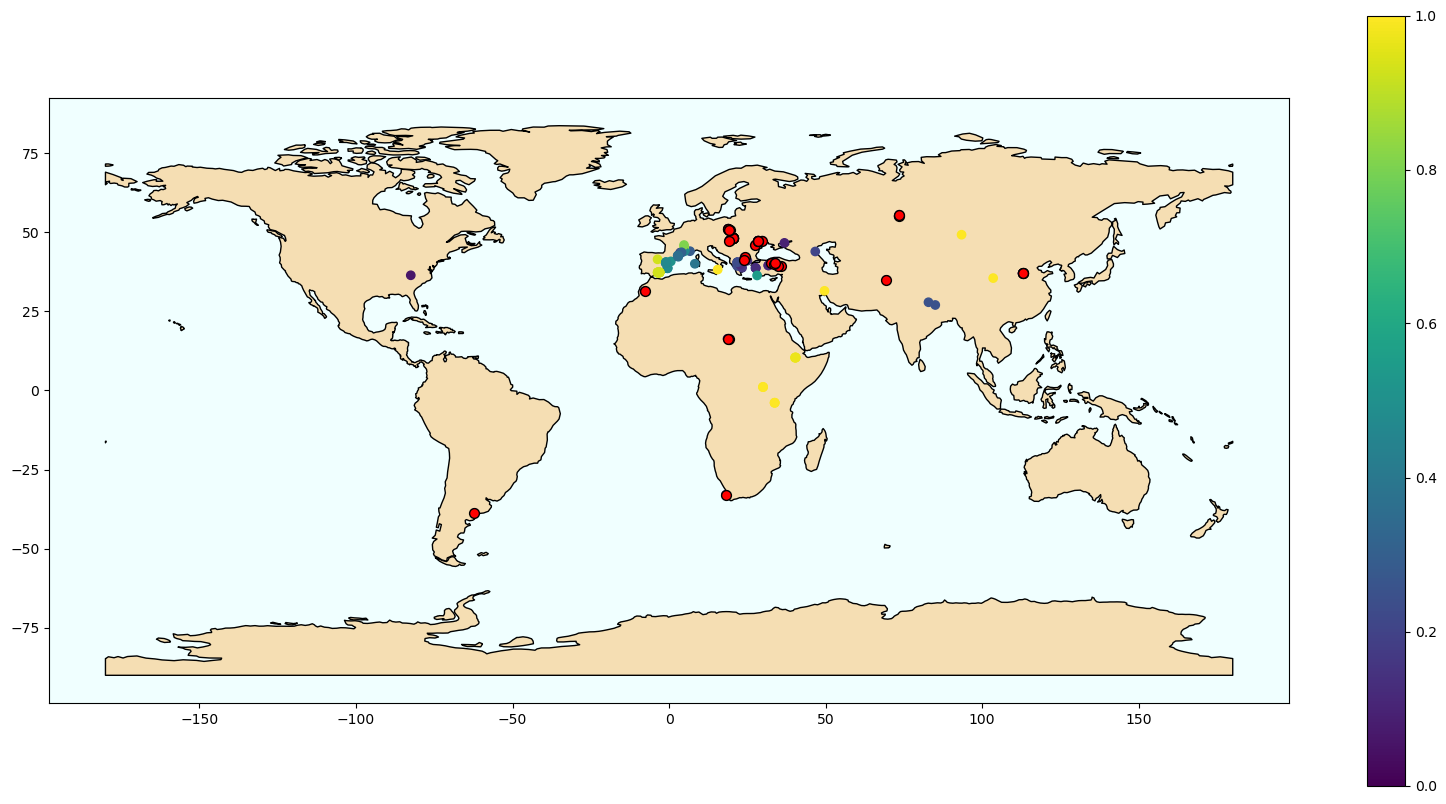

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN15


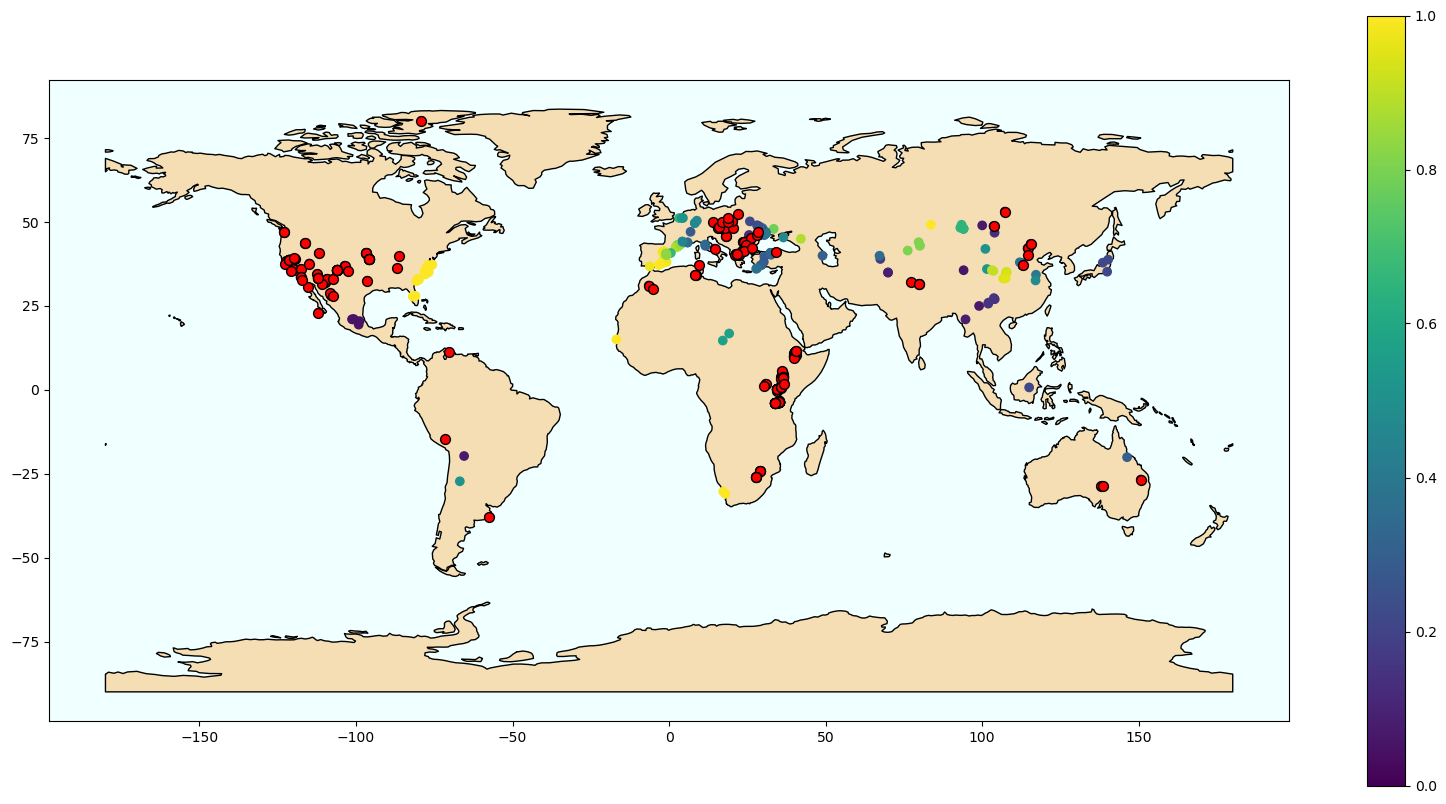

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN16


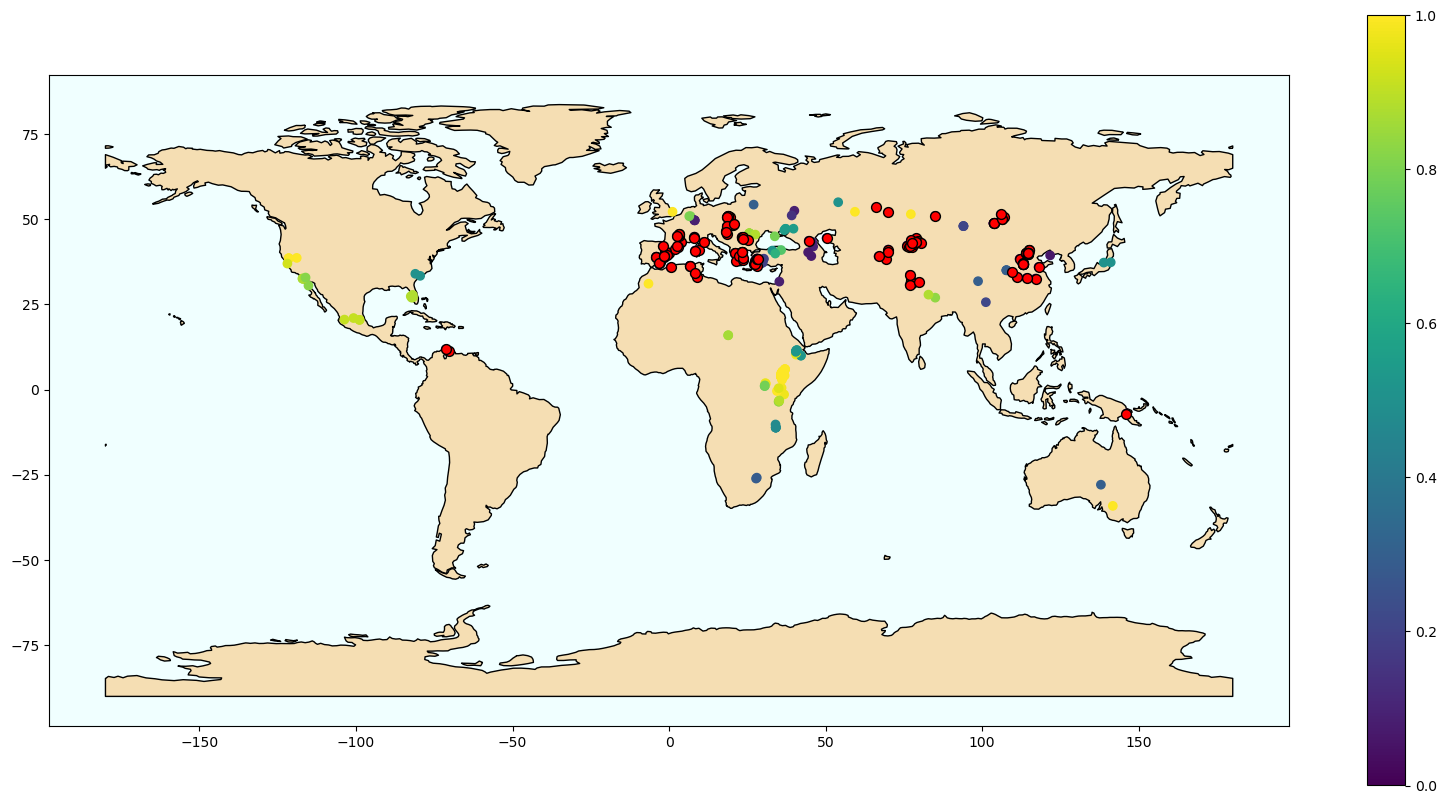

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MN17


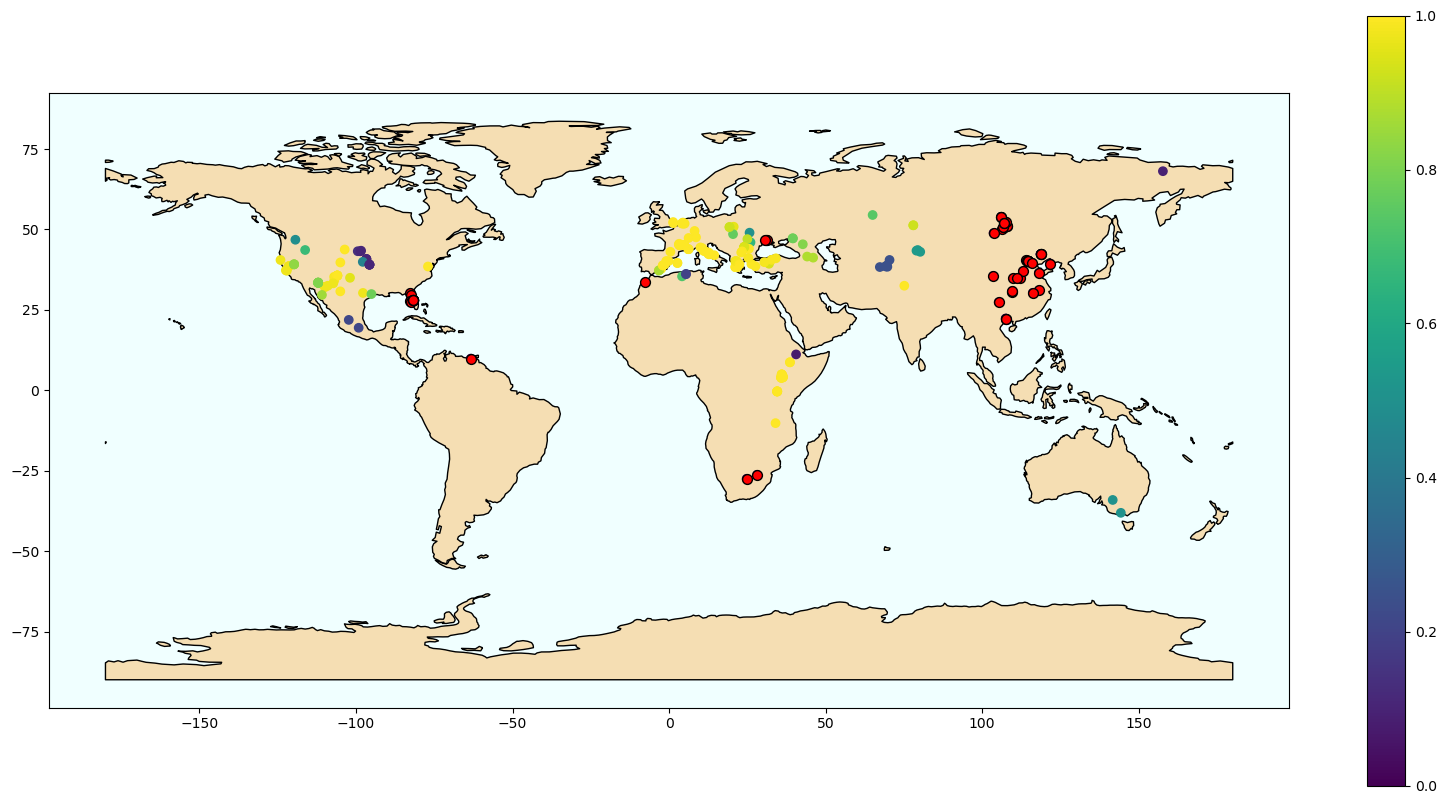

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MQ18


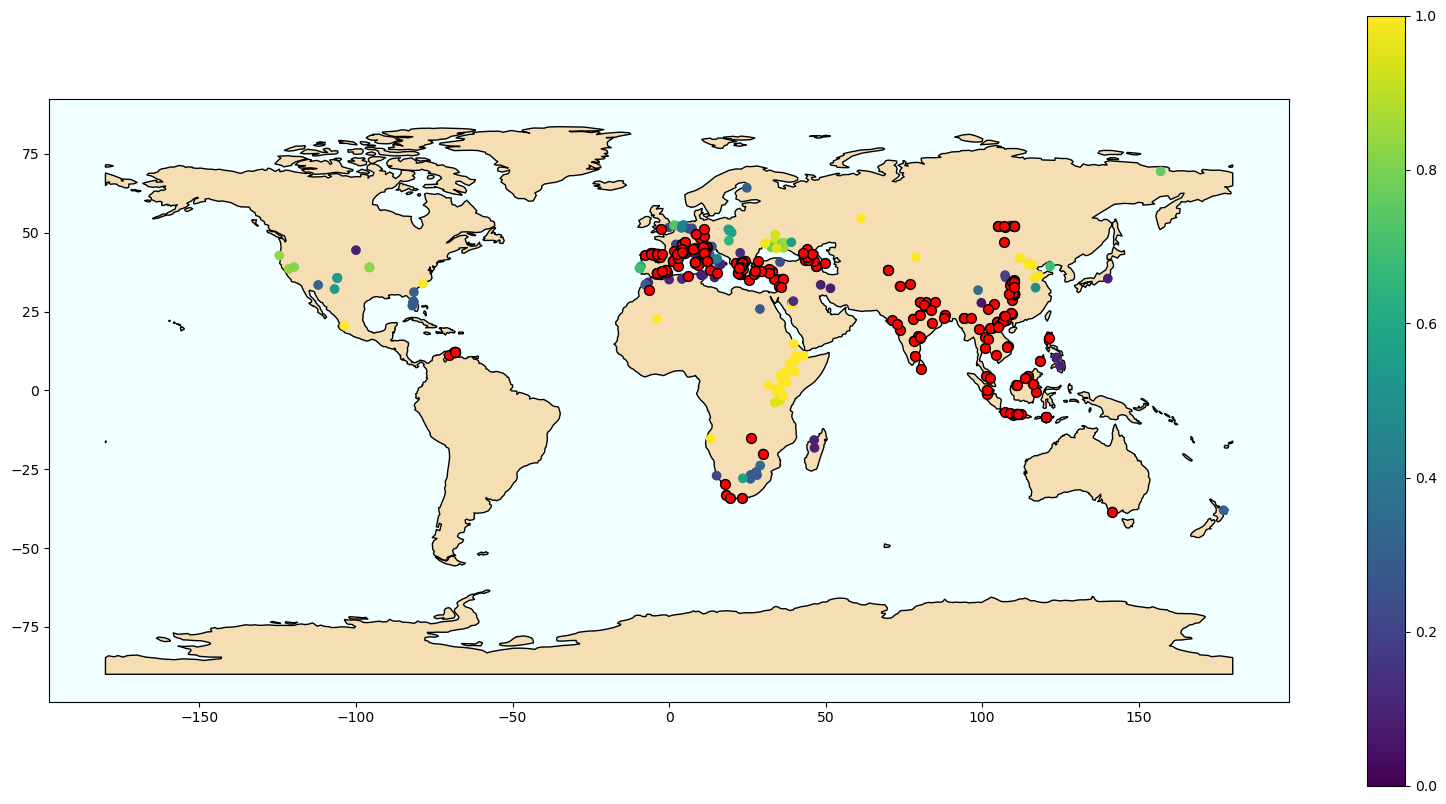

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


MQ19


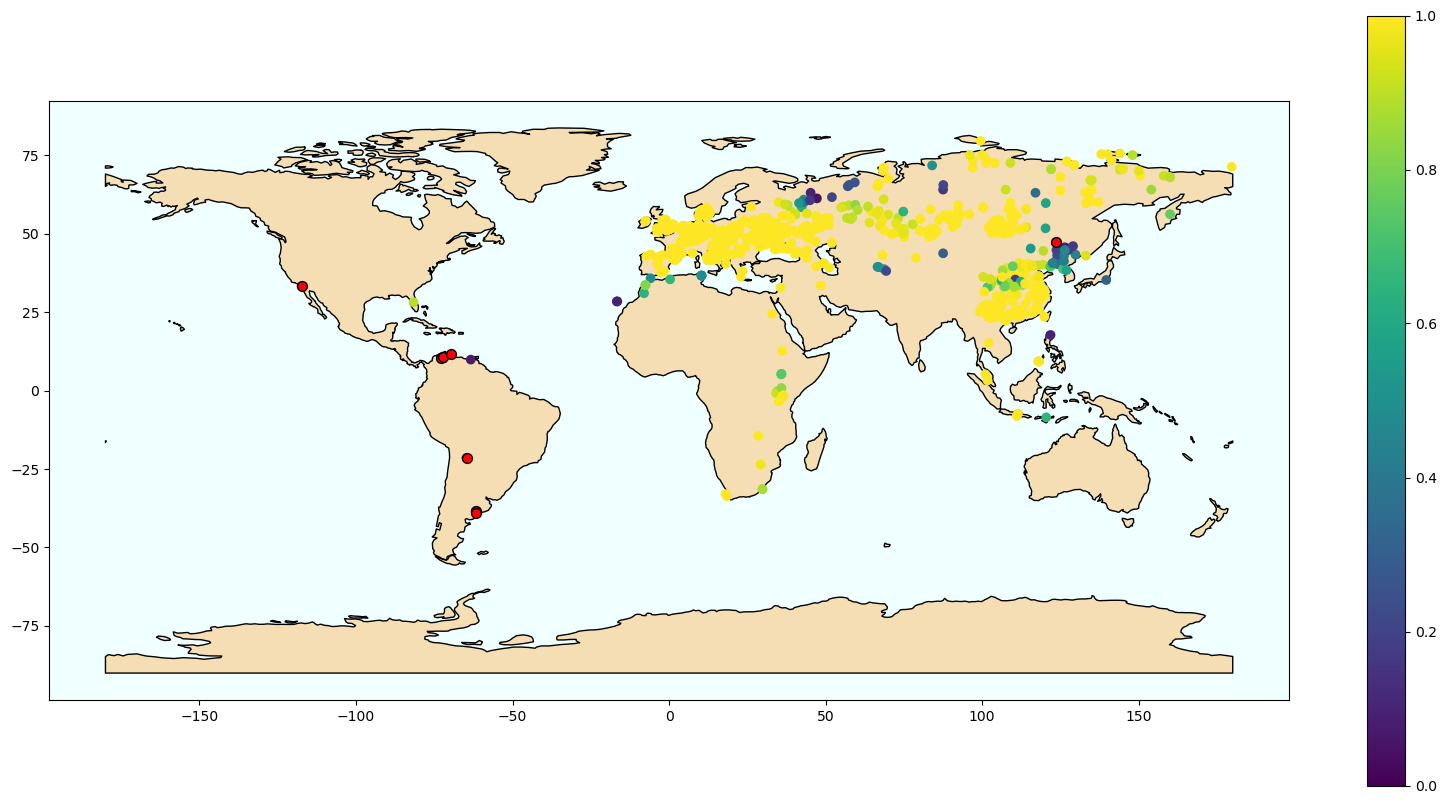

c:\ProgramData\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


post-MN


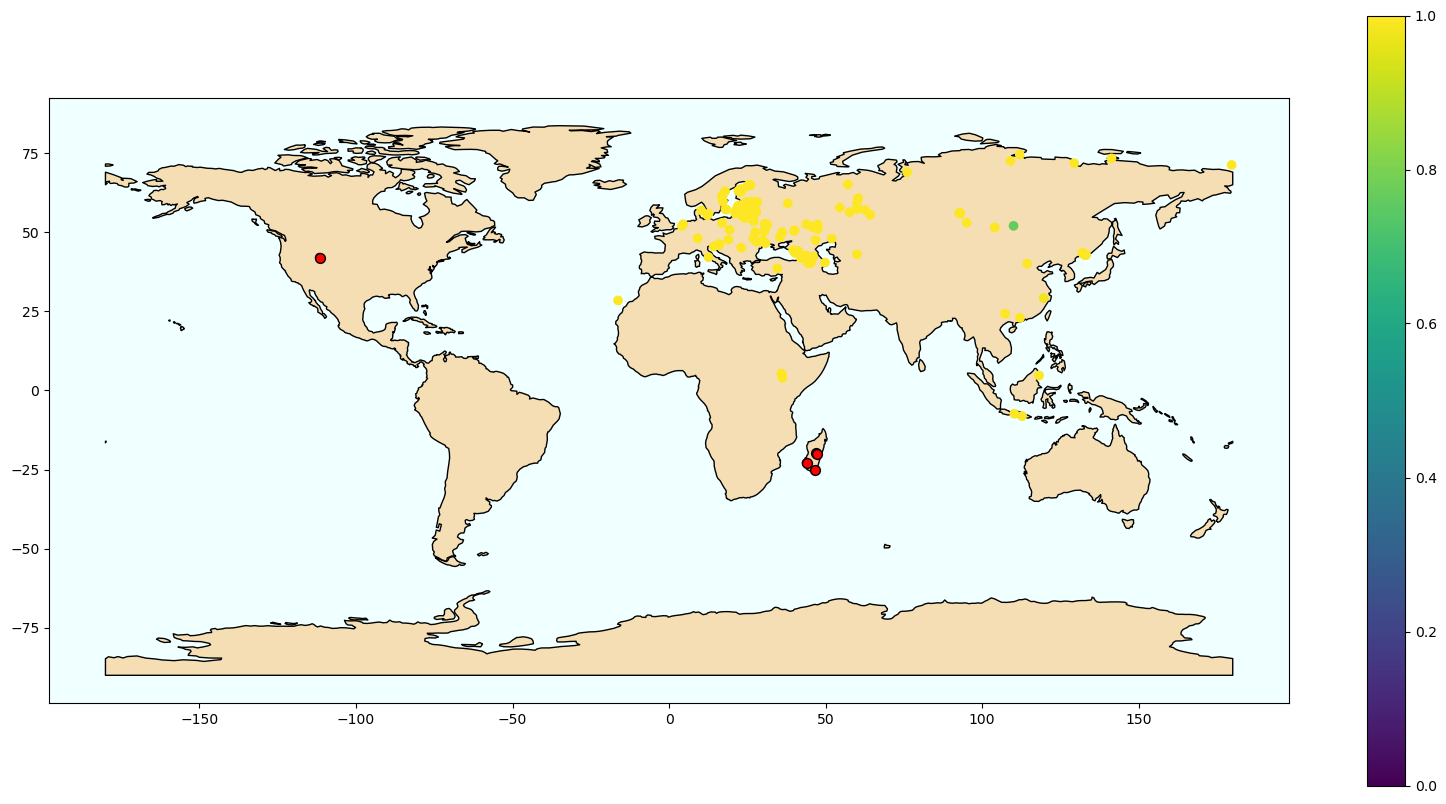

In [ ]:
world = geopandas.read_file(geodatasets.get_url("naturalearth land"))
#For each age
for i in custom_order: 
    localitiestime = localities2[localities2["AGE"]==i] 
    #Get only those localities with time == i
    fig , ax = plt.subplots( figsize= ( 20 , 10 ))
    world.plot( ax=ax ,color="wheat",edgecolor="black") 
    #Plot world
    ax.set_facecolor( "azure" )
    asd2 =  geopandas.GeoDataFrame(localitiestime,crs={'init': 'epsg:4326'},geometry=[shapely.geometry.Point(xy)
                                     for xy in zip(localitiestime["LONG"], localitiestime["LAT"])])
    highlight = asd2[asd2["p"]<0.05] 
    #Get localities with p<0.05
    ax.set_title = i
    asd2.plot(ax=ax, marker='o', column=localitiestime["p"],legend=True)
    #Plot localities with colorgradient showing p value
    if len(highlight)>0:
        highlight.plot(ax=ax, color='red', markersize=50, edgecolor='black', label="Observations with p<0.05")#Highlight values with p<0.05 by plotting them on top.
    print(i)
    plt.show()


10. Plotted the localities by age with color showing differences in p value. Highlighted localities with p<0.05.

Unsurprisingly pre-MN is mainly red and covers a lot of samples all over the world.

MN1 has very little observations. Most of them are in Europe and still ofcourse abnormally many new species.

MN2-MN3 A lot of red still, now localities all over the world. Not all of it red though. MN3 has Japan with a lot of new species

MN4 Still a lot of red in Europe. Everywhere else not that many observations.

MN5 No longer many new species in Europe. A lot of new species in North America still. Turkey gets a lot of new species

MN6 Now fairly quiet everywhere

MN7-8 Again fairly quiet but Turkey has a lot of new species again.

MN9 Now quite a bit of new species in Turkey, France, USA.

MN10-MN12 Some new species, but not a lot all over the world

MN13 Quite a bit more new species all over. Also in Europe

MN14 Not a lot of observations

MN15 A lot of new species in Europe and NA, Asia

MN16 Still a lot of new species in Europe and Asia.

MN17 A lot of new species in east-Asia, but not much elsewhere

MQ18 Suddenly a lot of new species in Europe, south-Asia and South Africa.

MQ19 A lot of observations in Europe and Asia, but not a lot of new species. Only in SA some new species. The observations in this age are likely species from the previous age.

post-MN Mainly no new species, but in Madagascar a lot of new species. This is interesting as a lot of the species in Madagascar are endemic.